# Demagnetisation calculation

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt

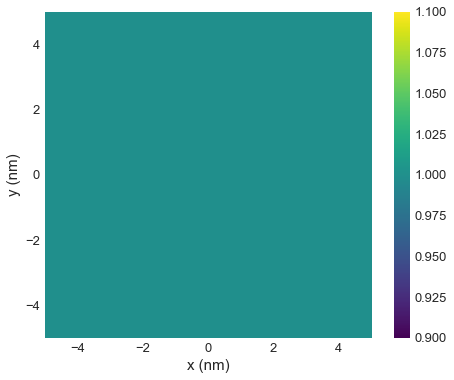

In [175]:
region = df.Region(p1=(-5e-9, -5e-9, -5e-9), p2=(5e-9, 5e-9, 5e-9))
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.DMI(D=3e-3, crystalclass='T') #1.58e-3
               #+ mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=1)
system.m.z.plane(z=-5e-9).mpl()

In [176]:
demag_oc = oc.compute(system.energy.demag.effective_field, system)

Running OOMMF (DockerOOMMFRunner) [2021/08/03 16:11]... (3.6 s)


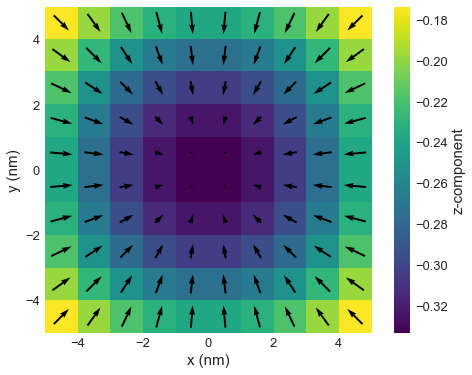

In [177]:
demag_oc.plane(z=0).mpl()

In [246]:
%%timeit
m_pad= system.m.pad(pad_width={'x': (0, system.m.mesh.n[0]**2),
                               'y': (0, system.m.mesh.n[1]**2),
                               'z': (0, system.m.mesh.n[2]**2)}, mode='constant')
mft = m_pad.rfftn
k = df.Field(mesh=mft.mesh, dim=3, value=lambda x: x)
k2 = k @ k + 1e-11
demag_ft = -mft + ((1/(1)) * k & (mft & k) / k2)
demag = demag_ft.irfftn
demag = df.Field(mesh=mesh, dim=3, value=demag.array[0:system.m.mesh.n[0],0:system.m.mesh.n[1],0:system.m.mesh.n[2],:])

11.8 s ± 457 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


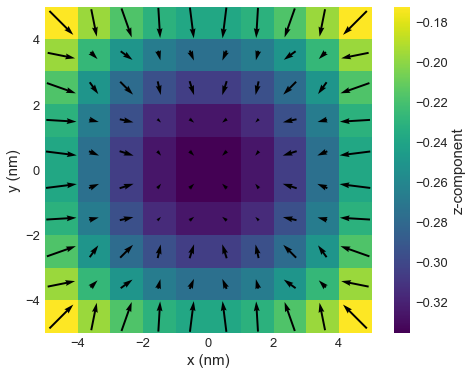

In [252]:
demag.plane(z=0e-9).mpl()

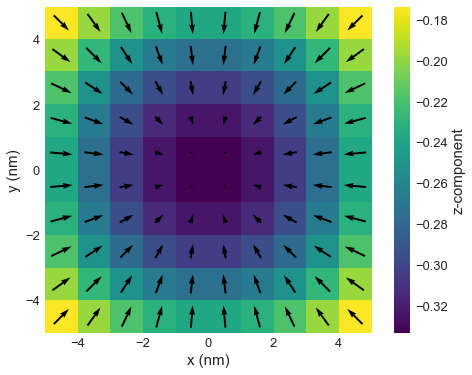

In [253]:
demag_oc.plane(z=0e-9).mpl()

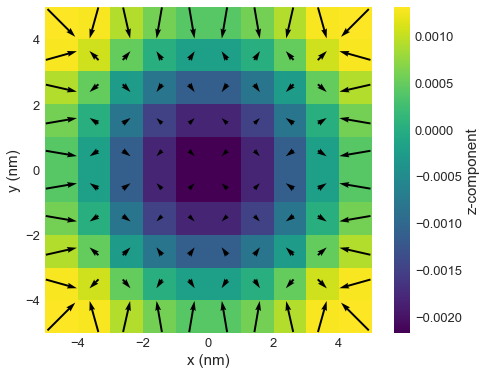

In [250]:
(demag-demag_oc).plane(z=0e-9).mpl()

In [202]:
m_pad= system.m.pad(pad_width={'x': (0, 0),
                               'y': (0, 0),
                               'z': (0, 0)}, mode='constant')
mft = m_pad.rfftn
k = df.Field(mesh=mft.mesh, dim=3, value=lambda x: x)
k2 = k @ k + 1e-11
demag_ft = -mft + ((1/(1)) * k & (mft & k) / k2)
demag = demag_ft.irfftn
demag = df.Field(mesh=mesh, dim=3, value=demag.array[0:system.m.mesh.n[0],0:system.m.mesh.n[1],0:system.m.mesh.n[2],:])

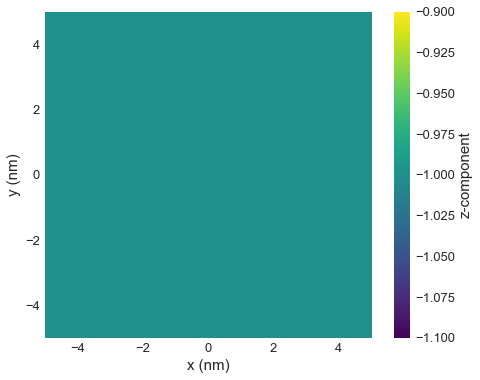

In [203]:
demag.plane(z=0e-9).mpl()

In [154]:
pad_arr = np.arange(9,50)#[system.m.mesh.n[0]-2, system.m.mesh.n[0]-1, system.m.mesh.n[0], system.m.mesh.n[0]+1, system.m.mesh.n[0]+2]
m_arr = []

for pad_s in pad_arr:
    m_pad= system.m.pad(pad_width={'x': (0, pad_s),
                                   'y': (0, pad_s),
                                   'z': (0, pad_s)}, mode='constant')
    mft = m_pad.rfftn
    k = df.Field(mesh=mft.mesh, dim=3, value=lambda x: x)
    k2 = k @ k + 1e-10
    demag_ft = -mft + ((1/(1)) * k & (mft & k) / k2)
    demag = demag_ft.irfftn
    demag = df.Field(mesh=mesh, dim=3, value=demag.array[0:10,0:10,0:10,:])
    m_arr.append(np.max(demag.z.plane(z=0e-9).array))

In [156]:
dme = m_arr/np.max(demag_oc.z.plane(z=0).array)

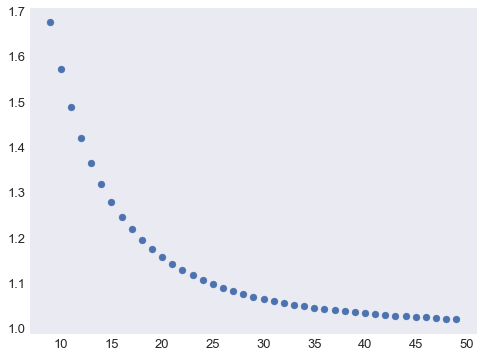

In [157]:
plt.scatter(pad_arr, dme)

In [153]:
np.savetxt('demag_error_x.txt', pad_arr)

In [148]:
zip(pad_arr,dme)